## Imports

### Libraries

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt

import numpy as np

### Custom

In [2]:
from cv_geoguessr.data.StreetViewImagesDataset import StreetViewImagesDataset

from cv_geoguessr.grid.grid_partitioning import Partitioning

ModuleNotFoundError: No module named 'cv_geoguessr'

## Colab specific

Run only when using Colab.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Model constants

In [11]:
NUMBER_OF_GRID_ELEMENTS = 100
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 100
SAMPLES_TO_SHOW = 5

CITY_BOUNDS_FILE = '../data/metadata/citybounds/london.csv'

COLAB_LONDON_PHOTO_DIR = lambda train: f'/content/drive/MyDrive/Documents/University/2021-2022/CS4245 Computer Vision/data/images/{"train" if train else "test"}/london'
LOCAL_LONDON_PHOTO_DIR = lambda train: f'../data/images/london/{"train" if train else "test"}'

LONDON_PHOTO_DIR = LOCAL_LONDON_PHOTO_DIR


## Load the data

### Create the data loaders

In [156]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224))
])

grid_partitioning = Partitioning(CITY_BOUNDS_FILE, 0.04)

train_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(True), grid_partitioning, data_transforms)
train_loader = DataLoader(train_data_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
test_data_set = StreetViewImagesDataset(LONDON_PHOTO_DIR(False), grid_partitioning, data_transforms)
test_loader = DataLoader(test_data_set, batch_size=TEST_BATCH_SIZE, shuffle=True)


### Preview some training images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


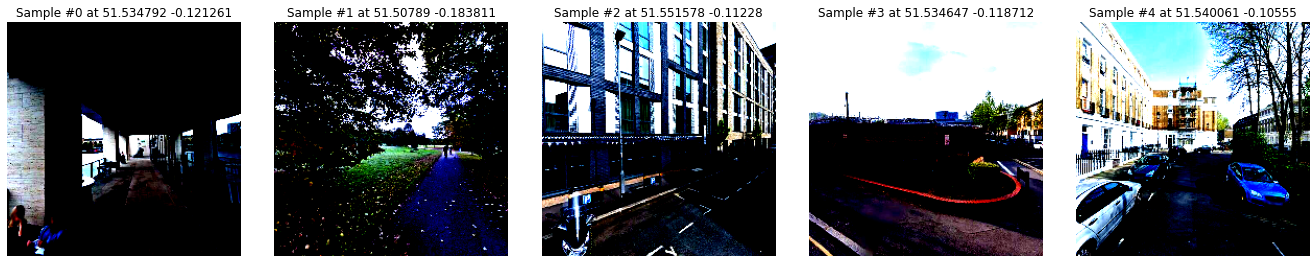

In [157]:
examples = enumerate(test_loader)
batch_idx, (example_images, example_coordinates) = next(examples)

fig = plt.figure()

for i in range(SAMPLES_TO_SHOW):
    image = example_images[i]
    coordinate = example_coordinates[i]

    print(image.shape)

    ax = plt.subplot(1, SAMPLES_TO_SHOW, i + 1)
    fig.set_size_inches(18.5, 10.5)
    plt.tight_layout()
    ax.set_title('Sample #{} at {} {}'.format(i, coordinate[0], coordinate[1]))
    ax.axis('off')

    # Annoying transformation to make it easy to show the image here
    image_for_viewing = torch.transpose(torch.transpose(image, 2, 0), 1, 0)
    
    plt.imshow(image_for_viewing)

plt.show()

## Download ResNet50

In [105]:
# resnet50 = models.resnet50(True, True)
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)

Using cache found in /Users/douwe/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


In [106]:
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [158]:
resnet50.eval()

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

aa = example_images[:10]

with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(aa), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

Using cache found in /Users/douwe/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


sample 0: [('prison, prison house', '7.7%'), ('bannister, banister, balustrade, balusters, handrail', '5.6%'), ('library', '5.4%'), ('sliding door', '3.4%'), ('patio, terrace', '3.0%')]
sample 1: [('lakeside, lakeshore', '25.0%'), ('park bench', '24.0%'), ('stone wall', '7.7%'), ('chainlink fence', '7.1%'), ('picket fence, paling', '3.3%')]
sample 2: [('streetcar, tram, tramcar, trolley, trolley car', '21.8%'), ('unicycle, monocycle', '11.7%'), ('moped', '6.4%'), ('shopping cart', '5.9%'), ('cinema, movie theater, movie theatre, movie house, picture palace', '4.0%')]
sample 3: [('freight car', '17.6%'), ('prison, prison house', '6.6%'), ('streetcar, tram, tramcar, trolley, trolley car', '3.2%'), ('steam locomotive', '2.6%'), ('mobile home, manufactured home', '2.5%')]
sample 4: [('minivan', '13.6%'), ('cab, hack, taxi, taxicab', '9.1%'), ('limousine, limo', '6.6%'), ('prison, prison house', '4.9%'), ('beach wagon, station wagon, wagon, estate car, beach waggon, station waggon, waggon',

In [167]:
fig = plt.figure()

i = 6
image = aa[i]

ax = plt.subplot(1, SAMPLES_TO_SHOW, i + 1)
fig.set_size_inches(18.5, 10.5)
plt.tight_layout()
ax.axis('off')

# Annoying transformation to make it easy to show the image here
image_for_viewing = torch.transpose(torch.transpose(image, 2, 0), 1, 0)

plt.imshow(image_for_viewing)

plt.show()

torch.Size([3, 224, 224])


ValueError: num must be 1 <= num <= 5, not 7

<Figure size 432x288 with 0 Axes>

tensor([[[ 1.3071,  1.2815,  1.1815,  ...,  0.6981,  0.6692,  0.6072],
         [ 1.2104,  1.1928,  1.0997,  ...,  0.7075,  0.6257,  0.6225],
         [ 1.1217,  1.1136,  1.0474,  ...,  0.6708,  0.6553,  0.6205],
         ...,
         [ 0.9669,  0.9708,  0.9737,  ..., -2.8186, -2.7946, -2.7598],
         [ 0.9552,  0.9572,  0.9945,  ..., -2.9036, -2.9653, -2.9413],
         [ 0.9305,  0.9873,  1.0227,  ..., -2.8358, -2.9637, -2.5255]],

        [[ 0.0981,  0.1275,  0.1305,  ...,  0.1788,  0.1674,  0.1590],
         [ 0.0665,  0.0323, -0.0167,  ...,  0.1761,  0.1642,  0.1590],
         [-0.0932, -0.0948, -0.0915,  ...,  0.1728,  0.1722,  0.1633],
         ...,
         [ 0.0665,  0.0693,  0.0656,  ..., -0.4598, -0.4500, -0.4513],
         [ 0.0718,  0.0714,  0.0770,  ..., -0.4581, -0.4557, -0.4681],
         [ 0.0692,  0.0770,  0.0802,  ..., -0.4509, -0.4732, -0.3738]],

        [[ 0.0420,  0.0965,  0.0524,  ...,  0.2047,  0.2252,  0.2022],
         [-0.0602, -0.1844, -0.2598,  ...,  0

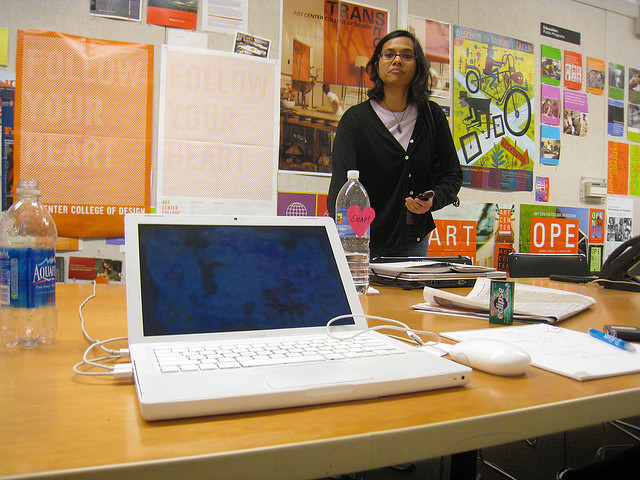

<PIL.Image.Image image mode=RGB size=640x480 at 0x1AC76E5B0>
(640, 480)


In [176]:
from PIL import Image               # to load images
from IPython.display import display # to display images

# print(aa[0])
# pil_img = Image()
# display(pil_img)
t = aa[0]


for uri, result in zip(uris, results):
    t = Image.open(requests.get(uri, stream=True).raw)
    break

t =  transforms.ToTensor()(t)
a = t.mean([1,2])
b = t.std([1,2])

transform_norm = transforms.Compose([
    transforms.Normalize(a, [1/0.5297932712/10, 1, 1]),
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224))
])


print(transform_norm(t))


print("t is: ", t.size())
from torchvision import transforms
im = transforms.ToPILImage()(t).convert("RGB")
display(im)
print(im)
print(im.size)

In [123]:
import torch
from PIL import Image
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)

Using cpu for inference


Using cache found in /Users/douwe/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /Users/douwe/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [124]:
uris = [
    'http://images.cocodataset.org/test-stuff2017/000000024309.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000028117.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000006149.jpg',
    'http://images.cocodataset.org/test-stuff2017/000000004954.jpg',
]

batch = torch.cat(
    [utils.prepare_input_from_uri(uri) for uri in uris]
).to(device)

In [128]:
batch.shape

torch.Size([4, 3, 224, 224])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 1.3070,  1.3242,  1.3413,  ...,  1.2557,  1.2557,  1.2043],
         [ 1.2899,  1.2899,  1.3584,  ...,  1.2557,  1.2728,  1.2214],
         [ 1.3413,  1.3927,  1.3927,  ...,  1.2557,  1.2385,  1.2385],
         ...,
         [ 1.5982,  1.6153,  1.6324,  ..., -1.5014, -1.5870, -1.7754],
         [ 1.5982,  1.6153,  1.5982,  ..., -1.5870, -1.5357, -1.5699],
         [ 1.6324,  1.6495,  1.6324,  ..., -1.6384, -1.6042, -1.5357]],

        [[ 1.3081,  1.3431,  1.3431,  ...,  1.2031,  1.2206,  1.1506],
         [ 1.3081,  1.2731,  1.3081,  ...,  1.2556,  1.2031,  1.2206],
         [ 1.3081,  1.3081,  1.3606,  ...,  1.2731,  1.2206,  1.2206],
         ...,
         [ 0.7129,  0.7304,  0.8004,  ..., -1.5105, -1.5630, -1.6331],
         [ 0.7129,  0.7479,  0.7829,  ..., -1.5455, -1.5280, -1.5630],
         [ 0.7479,  0.7829,  0.7654,  ..., -1.6155, -1.5455, -1.5105]],

        [[ 1.1585,  1.2631,  1.2980,  ...,  1.0714,  1.1237,  1.0539],
         [ 1.0888,  1.1062,  1.2282,  ...,  1

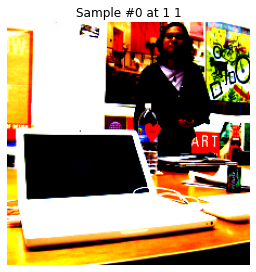

In [172]:
fig = plt.figure()

for i in range(1):
    image = batch[i]
    coordinate = (1, 1)
    print(image)

    print(image.shape)

    ax = plt.subplot(1, SAMPLES_TO_SHOW, i + 1)
    fig.set_size_inches(18.5, 10.5)
    plt.tight_layout()
    ax.set_title('Sample #{} at {} {}'.format(i, coordinate[0], coordinate[1]))
    ax.axis('off')

    # Annoying transformation to make it easy to show the image here
    image_for_viewing = torch.transpose(torch.transpose(image, 2, 0), 1, 0)
    
    plt.imshow(image_for_viewing)

plt.show()

In [125]:
with torch.no_grad():
    output = torch.nn.functional.softmax(resnet50(batch), dim=1)
    
results = utils.pick_n_best(predictions=output, n=5)

sample 0: [('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]
sample 1: [('mashed potato', '78.6%'), ('broccoli', '7.3%'), ('meat loaf, meatloaf', '2.5%'), ('plate', '1.8%'), ('guacamole', '0.2%')]
sample 2: [('racket, racquet', '25.4%'), ('tennis ball', '6.0%'), ('ping-pong ball', '2.0%'), ('catamaran', '0.3%'), ('bathtub, bathing tub, bath, tub', '0.3%')]
sample 3: [('groenendael', '12.7%'), ('Scottish deerhound, deerhound', '11.2%'), ('flat-coated retriever', '6.6%'), ('kelpie', '6.1%'), ('Great Dane', '3.1%')]


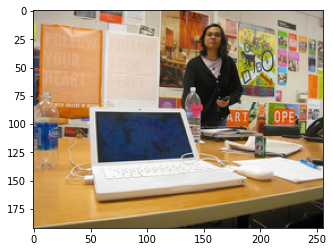

[('laptop, laptop computer', '34.7%'), ('mouse, computer mouse', '11.9%'), ('notebook, notebook computer', '10.9%'), ('monitor', '3.9%'), ('web site, website, internet site, site', '3.1%')]


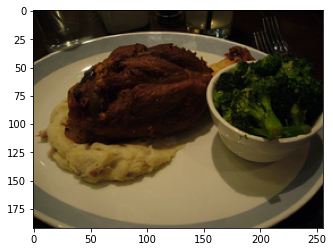

[('mashed potato', '78.6%'), ('broccoli', '7.3%'), ('meat loaf, meatloaf', '2.5%'), ('plate', '1.8%'), ('guacamole', '0.2%')]


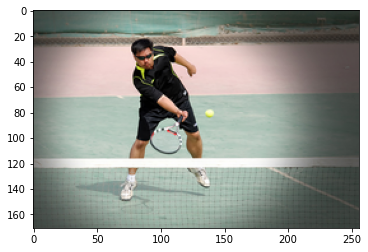

[('racket, racquet', '25.4%'), ('tennis ball', '6.0%'), ('ping-pong ball', '2.0%'), ('catamaran', '0.3%'), ('bathtub, bathing tub, bath, tub', '0.3%')]


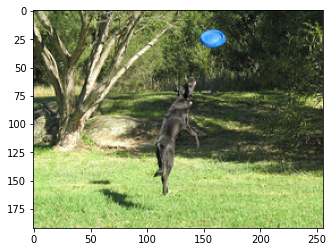

[('groenendael', '12.7%'), ('Scottish deerhound, deerhound', '11.2%'), ('flat-coated retriever', '6.6%'), ('kelpie', '6.1%'), ('Great Dane', '3.1%')]


In [126]:
for uri, result in zip(uris, results):
    img = Image.open(requests.get(uri, stream=True).raw)
    img.thumbnail((256,256), Image.ANTIALIAS)
    plt.imshow(img)
    plt.show()
    print(result)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
resnet50.fc = nn.Linear(resnet50.fc.in_features, NUMBER_OF_GRID_ELEMENTS)